### Install Required Packages

We would be running `Stable Diffusion 2` so enable `GPU` under `View Resources > Change runtime type`

In [1]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-87ae32fa-a0d5-9461-ce0d-f1ad1c47c6d7)


In [2]:
!git clone https://github.com/RishiDarkDevil/TITAN.git
%cd TITAN

Cloning into 'TITAN'...
remote: Enumerating objects: 165, done.
remote: Counting objects: 100% (165/165), done.
remote: Compressing objects: 100% (108/108), done.
remote: Total 165 (delta 102), reused 111 (delta 51), pack-reused 0
Receiving objects: 100% (165/165), 25.64 KiB | 12.82 MiB/s, done.
Resolving deltas: 100% (102/102), done.
/content/TITAN


In [3]:
# %cd ..
# import shutil
# shutil.rmtree('TITAN')

In [4]:
%%capture
!pip install -r requirements.txt
!pip install accelerate  # this is to reduce CPU model load overhead
!pip install ftfy regex tqdm
# !pip install git+https://github.com/openai/CLIP.git # for CLIP Re-Ranking
# !pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/$CUDA_VERSION/torch$TORCH_VERSION/index.html

### Load Necessary Libraries

In [5]:
# General
import os
import json
import datetime
from tqdm import tqdm
import base64
import IPython
import random
import requests
from io import BytesIO
from math import trunc

# Plotting
from matplotlib import pyplot as plt

# Data Handling
import pandas as pd
import numpy as np
from pycocotools.coco import COCO

# Image Processing
from PIL import Image
from PIL import ImageDraw as PILImageDraw
import cv2

# Language Processing
from titan import PromptHandler

# Image Generation
from diffusers import StableDiffusionPipeline
import daam

# Model
import torch
# import clip

In [6]:
from titan import PromptHandler
from titan import ObjectAnnotator
from titan import TITANDataset
from titan import merge_annotation_files
from titan import merge_caption_files
from titan import TITANViz

### Load Data

The below list is a placeholder for any list of prompts, we will be replacing it with a list of prompts from `MS-COCO` text annotations later.

In [7]:
prompts = [
  "A group of people stand in the back of trucks filled with cotton.",
  "A mother and three children collecting garbage from a blue and white garbage can on the street.",
  "A woman is sitting in a chair reading a book with her head resting on her free hand.",
  "A brown and white dog exiting a yellow and blue ramp in a grassy area.",
  "A boy stands on a rocky mountain.",
  'This recipe is for making a macaroni salad. Cook macaroni and let it cool. Then mix it with cheese cubes, celery, green pepper, and pimento. In a separate bowl, blend mayonnaise, vinegar, salt, and dill weed, and add it to the macaroni mix. Toss lightly and refrigerate. Serve in a lettuce-lined bowl if desired. This recipe makes 6 servings.'
  ]

In [8]:
prompt_handler = PromptHandler()

Loading Models...

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


INFO:stanza:Downloading default packages for language: en (English) ...


INFO:stanza:Finished downloading models and saved to /root/stanza_resources.
INFO:stanza:Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


INFO:stanza:Loading these models for language: en (English):
| Processor | Package  |
------------------------
| tokenize  | combined |
| pos       | combined |
| lemma     | combined |

INFO:stanza:Using device: cuda
INFO:stanza:Loading: tokenize
INFO:stanza:Loading: pos
INFO:stanza:Loading: lemma
INFO:stanza:Done loading processors!


Done


In [9]:
processed_prompts = prompt_handler.clean_prompt(prompts)

Token indices sequence length is longer than the specified maximum sequence length for this model (82 > 77). Running this sequence through the model will result in indexing errors


Tokenizing...Done
POS Tagging and Lemmatizing...Done
Processing...Done


In [10]:
processed_prompts

[('a group of people stand in the back of trucks filled with cotton .',
  ['group', 'people', 'back', 'trucks', 'cotton'],
  ['group', 'people', 'back', 'truck', 'cotton']),
 ('a mother and three children collecting garbage from a blue and white garbage can on the street .',
  ['mother', 'children', 'garbage', 'garbage', 'street'],
  ['mother', 'child', 'garbage', 'garbage', 'street']),
 ('a woman is sitting in a chair reading a book with her head resting on her free hand .',
  ['woman', 'chair', 'book', 'head', 'hand'],
  ['woman', 'chair', 'book', 'head', 'hand']),
 ('a brown and white dog exiting a yellow and blue ramp in a grassy area .',
  ['dog', 'ramp', 'area'],
  ['dog', 'ramp', 'area']),
 ('a boy stands on a rocky mountain .',
  ['boy', 'mountain'],
  ['boy', 'mountain'])]

### Setting up the Pipeline

#### Set some parameters

In [11]:
DIFFUSION_MODEL_PATH = 'stabilityai/stable-diffusion-2-base'

In [12]:
DEVICE = 'cuda' # device
NUM_IMAGES_PER_PROMPT = 1 # Number of images to be generated per prompt
NUM_INFERENCE_STEPS = 50 # Number of inference steps to the Diffusion Model
SAVE_AFTER_NUM_IMAGES = 1 # Number of images after which the annotation and caption files will be saved

Now, let's load the `stabilityai/stable-diffusion-2-base` diffusion model.

In [13]:
model = StableDiffusionPipeline.from_pretrained(DIFFUSION_MODEL_PATH)
model = model.to(DEVICE) # Set it to something else if needed, make sure DAAM supports that

Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

### Generating Dataset

In [14]:
titan_dataset = TITANDataset()

In [15]:
try:

  # Iterating over the processed_prompts
  for i, processed_prompt in enumerate(processed_prompts):

    # Generating images for these processed prompts and annotating them
    for j in range(NUM_IMAGES_PER_PROMPT):

      # traversing the processed prompts
      prompt, _, _ = processed_prompt

      print()
      print(f'Prompt No.: {i+1}/{len(processed_prompts)}')
      print(f'Image No.: {j+1}/{NUM_IMAGES_PER_PROMPT}')
      print('Generating Image...')

      # generating images
      with daam.trace(model) as trc:
        output_image = model(prompt, num_inference_steps=NUM_INFERENCE_STEPS).images[0]
        global_heat_map = trc.compute_global_heat_map()
      
      output_image.save(os.path.join(titan_dataset.image_dir, f'{i}_{j}.png'))
      print(f'Saved Generated Image... {i}_{j}.png')

      print(f'Adding Annotation for {i}_{j}.png')
      titan_dataset.annotate(output_image, f'{i}_{j}.png', global_heat_map, processed_prompt)

      if len(titan_dataset.images) % SAVE_AFTER_NUM_IMAGES == 0:
        print()
        titan_dataset.save()
        titan_dataset.clear()
    
  if len(titan_dataset.annotations):
    titan_dataset.save()
    titan_dataset.clear()

except KeyboardInterrupt: # In case of KeyboardInterrupt save the annotations and captions
  titan_dataset.save()
  titan_dataset.clear()



Prompt No.: 1/5
Image No.: 1/1
Generating Image...


  0%|          | 0/51 [00:00<?, ?it/s]

Saved Generated Image... 0_0.png
Adding Annotation for 0_0.png


5it [00:00, 38.89it/s]


Saved Annotations... object-detect-1.json
Saved Captions... object-caption-1.json

Prompt No.: 2/5
Image No.: 1/1
Generating Image...


  0%|          | 0/51 [00:00<?, ?it/s]

Saved Generated Image... 1_0.png
Adding Annotation for 1_0.png


5it [00:00, 294.27it/s]


Saved Annotations... object-detect-2.json
Saved Captions... object-caption-2.json

Prompt No.: 3/5
Image No.: 1/1
Generating Image...


  0%|          | 0/51 [00:00<?, ?it/s]

Saved Generated Image... 2_0.png
Adding Annotation for 2_0.png


5it [00:00, 314.42it/s]


Saved Annotations... object-detect-3.json
Saved Captions... object-caption-3.json

Prompt No.: 4/5
Image No.: 1/1
Generating Image...


  0%|          | 0/51 [00:00<?, ?it/s]

Saved Generated Image... 3_0.png
Adding Annotation for 3_0.png


3it [00:00, 251.42it/s]


Saved Annotations... object-detect-4.json
Saved Captions... object-caption-4.json

Prompt No.: 5/5
Image No.: 1/1
Generating Image...


  0%|          | 0/51 [00:00<?, ?it/s]

Saved Generated Image... 4_0.png
Adding Annotation for 4_0.png


2it [00:00, 223.55it/s]


Saved Annotations... object-detect-5.json
Saved Captions... object-caption-5.json


We generate multiple annotation files we will have to merge them together into a single json file. The following cell does just that and results into a single `annotations.json`.

In [16]:
merge_annotation_files()

Starting Annotation Files Merge...
Number of Annotation Files to be merged: 5
Annotation File Names: object-detect-3.json object-detect-1.json object-detect-5.json object-detect-2.json object-detect-4.json


100%|██████████| 5/5 [00:00<00:00, 670.62it/s]


Saved Annotation file... annotations.json
A successful merge!


We generate multiple caption files we will have to merge them together into a single json file. The following cell does just that and results into a single `captions.json`.

In [17]:
merge_caption_files()

Starting Caption Files Merge...
Number of Caption Files found: 5
Caption Files found: object-caption-2.json object-caption-4.json object-caption-5.json object-caption-3.json object-caption-1.json


100%|██████████| 5/5 [00:00<00:00, 1521.66it/s]


Saved Caption file... captions.json
A successful merge!


### Visualize Generated Dataset

Load the `TITAN` Dataset.

In [18]:
titan_visualizer = TITANViz()

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [19]:
titan_visualizer.visualize_annotation(image_id = 1)

----- INTERACTIVE IMAGE ANNOTATION VISUALIZER -----


Output()

In [20]:
titan_visualizer.visualize_annotation(image_id = 2)

----- INTERACTIVE IMAGE ANNOTATION VISUALIZER -----


Output()

### CLIP Re-Ranking

Now, as we are generating `NUM_IMAGES_PER_PROMPT` many images for each caption. We might want to check the fidelity and quality of the generated images without manually scrutinizing each image. Thus, we use the powerful `CLIP` joint embedding model to see the similarity between the input caption and the generated image in the joint multi-modal space and we will rank the images based on that.

In [ ]:
# We will store the rankings in a new folder under Data-Generated
os.mkdir('Data-Generated/rankings')

In [ ]:
# Replace the name of the model with any of the models from clip.available_models() 
clip_model, clip_preprocess = clip.load("ViT-B/32", device=DEVICE) 

100%|████████████████████████████████████████| 338M/338M [00:02<00:00, 137MiB/s]


In [ ]:
# Given the input of an image_id it finds the similarity score of that image with the caption which generated it
def clip_score_images(image_id): 

  # Load Image Details corresponding to the image_id
  try:
    img_info = coco_caption.loadImgs([image_id])[0]
    img_file_name = img_info['file_name']
  except KeyError:
    print(f'Image with ID: {image_id} is not present.')
    return 0

  # Load Caption Details corresponding to the image_id
  cap_ids = coco_caption.getAnnIds(imgIds=[image_id])
  cap = coco_caption.loadAnns(cap_ids)

  # Load Image corresponding to the image_id
  im = Image.open(os.path.join(image_dir, img_file_name))
  image = clip_preprocess(im).unsqueeze(0).to(DEVICE)
  text = clip.tokenize([cap[0]['caption']]).to(DEVICE)

  # Encode the image and text, pass it through the model and obtain score
  with torch.no_grad():
    logits_per_image, logits_per_text = clip_model(image, text) # Cosine similarity between the image and text feature vectors for similarity
    score = logits_per_image.item()

  # Return score
  return score

In [ ]:
# Finds the list of image_ids generated by prompt at an index in ascending order of clip scores.
rankings = list()
print('Finding CLIP Ranking...')
for idx in tqdm(range(len(prompts))):
  ranking_det = {
      'prompt_id': idx + 1,
      'image_ids': NUM_IMAGES_PER_PROMPT * idx + 1 + np.argsort([clip_score_images(img_id) for img_id in range(NUM_IMAGES_PER_PROMPT * idx + 1, NUM_IMAGES_PER_PROMPT * (idx + 1) + 1)])
  }
  rankings.append(ranking_det)
print()
print('Done.')

Finding CLIP Ranking...


100%|██████████| 1/1 [00:00<00:00,  4.68it/s]


Done.


In [ ]:
# Creating the ranking file
ranking_file = {
    'info': info,
    'licenses': licenses,
    'prompts': [{'id': idx+1, 'text': prompts[idx]} for idx in range(len(prompts))],
    'images': annotation_file['images'],
    'rankings': rankings
}

In [ ]:
# Saving annotations and captions when called -- mainly to avoid code repetition
# Serializing json
json_rank_det = json.dumps(ranking_file, indent=4, cls=NpEncoder)

# Writing json
with open(f"Data-Generated/rankings/rankings.json", "w") as outfile:
  outfile.write(json_rank_det)

print('Saved Ranking.. rankings.json')

# Delete json from python env
del json_rank_det

Saved Ranking.. rankings.json


In [ ]:
# Loading the rankings.json file
with open('Data-Generated/rankings/rankings.json') as json_file:
  rank_file = json.load(json_file)

Below we see the re-ranked images displayed in ascending order of their ranking scores.

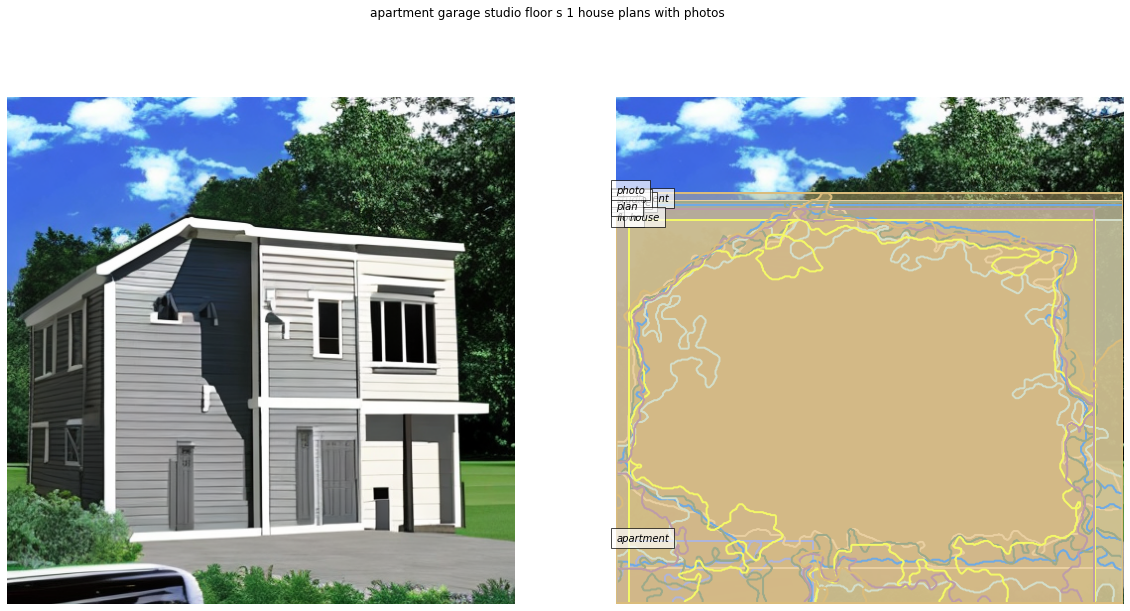

In [ ]:
# Displaying the annotations and generated images based on CLIP ranking ordering
for prompt_id in range(1, len(prompts)+1):
  ranking_info = [rank for rank in rank_file['rankings'] if rank['prompt_id'] == prompt_id]
  for img_id in ranking_info[0]['image_ids']:
    try:
      visualize_annotation(img_id)
    except:
      print(f'Skipping {img_id}th image')